In [1]:
import pandas as pd
import numpy as np

In [2]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "QLIKE" and crit != "MAD" and crit != "MAPE"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        #for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
        #    is_actual_ok = compiled_regex(str(abs(actual)))
        #    is_pred1_ok = compiled_regex(str(abs(pred1)))
        #    is_pred2_ok = compiled_regex(str(abs(pred2)))
        #    if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
        #        msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
        #        rt = -1
        #        return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "QLIKE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((abs(actual)/abs(p1)-np.log(abs(actual)/abs(p1))-1))
            e2_lst.append((abs(actual)/abs(p2)-np.log(abs(actual)/abs(p2))-1))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return DM_stat

In [3]:
HAR=pd.read_excel("HAR Forecasts.xlsx")#, index_col= "Date")

In [4]:
NBEATSx=pd.read_excel("NBEATSx forecasts.xlsx")#, index_col= "Date")

In [5]:
NHITS=pd.read_excel("NHITS forecasts.xlsx")#, index_col= "Date")

In [6]:
TimesNet=pd.read_excel("TimesNet forecasts.xlsx")#, index_col= "Date")

In [7]:
TFT=pd.read_excel("TFT forecasts.xlsx")#, index_col= "Date")
Autoformer=pd.read_excel("Autoformer forecasts.xlsx")
Informer=pd.read_excel("Informer forecasts.xlsx")
PatchTST=pd.read_excel("PatchTST forecasts.xlsx")

In [8]:
Actuals=pd.read_excel("Actuals.xlsx")

In [9]:
mask=HAR['Date'].isin(NBEATSx['Date'])
HAR=HAR.loc[mask]

In [10]:
mask=NBEATSx['Date'].isin(HAR['Date'])
NBEATSx=NBEATSx.loc[mask]

In [11]:
mask=NHITS['Date'].isin(HAR['Date'])
NHITS=NHITS.loc[mask]

In [12]:
mask=TimesNet['Date'].isin(HAR['Date'])
TimesNet=TimesNet.loc[mask]

In [13]:
mask=TFT['Date'].isin(HAR['Date'])
TFT=TFT.loc[mask]

In [14]:
mask=Autoformer['Date'].isin(HAR['Date'])
Autoformer=Autoformer.loc[mask]

In [15]:
mask=Informer['Date'].isin(HAR['Date'])
Informer=Informer.loc[mask]

In [16]:
mask=PatchTST['Date'].isin(HAR['Date'])
PatchTST=PatchTST.loc[mask]

In [17]:
mask=Actuals['Date'].isin(HAR['Date'])
Actuals=Actuals.loc[mask]

In [18]:
HAR.set_index('Date',inplace=True)
NBEATSx.set_index('Date',inplace=True)
NHITS.set_index('Date',inplace=True)
TimesNet.set_index('Date',inplace=True)
TFT.set_index('Date',inplace=True)
Autoformer.set_index('Date',inplace=True)
Informer.set_index('Date',inplace=True)
PatchTST.set_index('Date',inplace=True)
Actuals.set_index('Date',inplace=True)

# DM tests with MSE

In [19]:
Stocks = []
for i in range(len(NHITS.columns)):
  Stocks.append(NHITS.columns[i])


If DM_stat is negative, first model is better, otherwise second one is better

In [20]:
DM_statistics_NBEATSx_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MSE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NBEATSx_is_statistically_better)
PatchTST_better_NBEATSx=len(Stocks_where_PatchTST_is_statistically_better)
NBEATSx_better_PatchTST=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: 42
Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:
['ACN', 'ADP', 'AMGN', 'AMT', 'BA', 'BAC', 'BSX', 'C', 'CB', 'CMCSA', 'COP', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DUK', 'GE', 'GS', 'HON', 'INTU', 'ISRG', 'JPM', 'LLY', 'LMT', 'MA', 'MCD', 'MRK', 'NKE', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'SBUX', 'SO', 'SYK', 'TMO', 'UNP', 'UPS', 'USB', 'WFC']
Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: 0
Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:
[]


In [21]:
DM_statistics_HAR_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MSE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than HAR: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than HAR:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than PatchTST: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_HAR_is_statistically_better)
PatchTST_better_HAR=len(Stocks_where_PatchTST_is_statistically_better)
HAR_better_PatchTST=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than HAR: 11
Stocks where PatchTST yields statistically significant better forecasts than HAR:
['AMGN', 'AMZN', 'BA', 'CB', 'CRM', 'CVS', 'GE', 'GILD', 'NFLX', 'UPS', 'WFC']
Number of stocks where HAR yields statistically significant better forecasts than PatchTST: 17
Stocks where HAR yields statistically significant better forecasts than PatchTST:
['ABT', 'ACN', 'CMCSA', 'CME', 'CSCO', 'GS', 'HD', 'IBM', 'INTC', 'ISRG', 'KO', 'LOW', 'MCD', 'MDT', 'NKE', 'ORCL', 'TXN']


In [22]:
DM_statistics_TFT_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MSE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TFT: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TFT:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TFT_is_statistically_better)
PatchTST_better_TFT=len(Stocks_where_PatchTST_is_statistically_better)
TFT_better_PatchTST=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TFT: 70
Stocks where PatchTST yields statistically significant better forecasts than TFT:
['ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MO', 'MRK', 'MS', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'TGT', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where TFT yields statistically significant better forecasts than PatchTST: 0
Stocks where TFT yields statistically significant better forecasts than PatchTST:
[]


In [23]:
DM_statistics_NHITS_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NHITS_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NHITS[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MSE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NHITS:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NHITS_is_statistically_better)}")
print(f"Stocks where NHITS yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NHITS_is_statistically_better)
PatchTST_better_NHITS=len(Stocks_where_PatchTST_is_statistically_better)
NHITS_better_PatchTST=len(Stocks_where_NHITS_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: 51
Stocks where PatchTST yields statistically significant better forecasts than NHITS:
['ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AXP', 'BA', 'BAC', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'COP', 'COST', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'GE', 'GS', 'HON', 'INTU', 'JNJ', 'JPM', 'KO', 'MA', 'MCD', 'MDT', 'MO', 'MRK', 'MS', 'NKE', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'SBUX', 'SO', 'SYK', 'TMO', 'UNH', 'UNP', 'UPS', 'USB', 'WFC']
Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: 0
Stocks where NHITS yields statistically significant better forecasts than PatchTST:
[]


In [24]:
DM_statistics_TimesNet_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TimesNet_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TimesNet[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MSE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TimesNet:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TimesNet_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0])):
  Stocks_where_TimesNet_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TimesNet_is_statistically_better)}")
print(f"Stocks where TimesNet yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TimesNet_is_statistically_better)
PatchTST_better_TimesNet=len(Stocks_where_PatchTST_is_statistically_better)
TimesNet_better_PatchTST=len(Stocks_where_TimesNet_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: 44
Stocks where PatchTST yields statistically significant better forecasts than TimesNet:
['AAPL', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMZN', 'BA', 'BAC', 'BMY', 'BSX', 'C', 'CB', 'CI', 'CMCSA', 'COP', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'GS', 'JPM', 'LLY', 'MA', 'MCD', 'MO', 'MRK', 'MS', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'TMO', 'UNP', 'UPS', 'USB', 'VZ', 'WFC']
Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: 0
Stocks where TimesNet yields statistically significant better forecasts than PatchTST:
[]


In [25]:
DM_statistics_Informer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Informer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Informer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MSE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Informer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Informer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Informer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Informer_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Informer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Informer_is_statistically_better)}")
print(f"Stocks where Informer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Informer_is_statistically_better)
PatchTST_better_Informer=len(Stocks_where_PatchTST_is_statistically_better)
Informer_better_PatchTST=len(Stocks_where_Informer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Informer: 67
Stocks where PatchTST yields statistically significant better forecasts than Informer:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AXP', 'BA', 'BAC', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CMCSA', 'COP', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'GE', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TMO', 'TXN', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where Informer yields statistically significant better forecasts than PatchTST: 1
Stocks where Informer yields statistically significant better forecasts than PatchTST:
['NFLX']


In [26]:
DM_statistics_Autoformer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Autoformer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Autoformer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MSE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Autoformer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Autoformer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Autoformer_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Autoformer_is_statistically_better)}")
print(f"Stocks where Autoformer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Autoformer_is_statistically_better)
PatchTST_better_Autoformer=len(Stocks_where_PatchTST_is_statistically_better)
Autoformer_better_PatchTST=len(Stocks_where_Autoformer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: 13
Stocks where PatchTST yields statistically significant better forecasts than Autoformer:
['AAPL', 'ADBE', 'AMGN', 'AMZN', 'CRM', 'GILD', 'INTC', 'JPM', 'MA', 'MRK', 'NVDA', 'QCOM', 'UPS']
Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: 0
Stocks where Autoformer yields statistically significant better forecasts than PatchTST:
[]


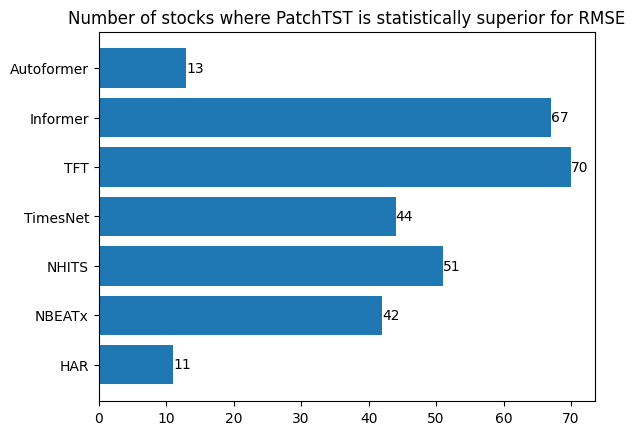

In [27]:


import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([PatchTST_better_HAR, PatchTST_better_NBEATSx, PatchTST_better_NHITS,
              PatchTST_better_TimesNet,PatchTST_better_TFT,PatchTST_better_Informer,PatchTST_better_Autoformer])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically superior for RMSE")
plt.show()

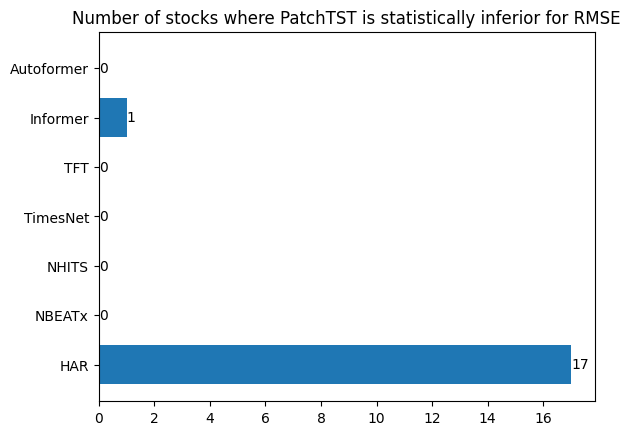

In [28]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([HAR_better_PatchTST, NBEATSx_better_PatchTST, NHITS_better_PatchTST,
              TimesNet_better_PatchTST,TFT_better_PatchTST,Informer_better_PatchTST,Autoformer_better_PatchTST])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically inferior for RMSE")
plt.show()

# DM tests with MAE

In [29]:
DM_statistics_NBEATSx_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAD")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NBEATSx_is_statistically_better)
PatchTST_better_NBEATSx=len(Stocks_where_PatchTST_is_statistically_better)
NBEATSx_better_PatchTST=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: 0
Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:
[]
Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: 35
Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:
['ABT', 'ACN', 'AMT', 'BDX', 'BMY', 'CI', 'CMCSA', 'CME', 'COST', 'CRM', 'D', 'DHR', 'DUK', 'FIS', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'KO', 'LOW', 'MMM', 'MO', 'MS', 'MSFT', 'NFLX', 'NKE', 'T', 'TGT', 'TJX', 'UNH', 'WMT']


In [30]:
DM_statistics_HAR_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAD")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than HAR: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than HAR:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than PatchTST: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_HAR_is_statistically_better)
PatchTST_better_HAR=len(Stocks_where_PatchTST_is_statistically_better)
HAR_better_PatchTST=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than HAR: 11
Stocks where PatchTST yields statistically significant better forecasts than HAR:
['AMGN', 'AMZN', 'BA', 'BAC', 'BSX', 'CB', 'CRM', 'GE', 'GILD', 'MS', 'NFLX']
Number of stocks where HAR yields statistically significant better forecasts than PatchTST: 43
Stocks where HAR yields statistically significant better forecasts than PatchTST:
['ABT', 'ACN', 'ADBE', 'ADP', 'AMT', 'BDX', 'CI', 'CMCSA', 'CME', 'COST', 'CSCO', 'DHR', 'DIS', 'DUK', 'FIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'KO', 'LMT', 'LOW', 'MCD', 'MDT', 'MMM', 'NKE', 'ORCL', 'PEP', 'PG', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNP', 'VZ', 'WMT']


In [31]:
DM_statistics_TFT_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAD")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TFT: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TFT:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TFT_is_statistically_better)
PatchTST_better_TFT=len(Stocks_where_PatchTST_is_statistically_better)
TFT_better_PatchTST=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TFT: 65
Stocks where PatchTST yields statistically significant better forecasts than TFT:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DIS', 'FIS', 'GOOG', 'GS', 'HD', 'HON', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MRK', 'MS', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where TFT yields statistically significant better forecasts than PatchTST: 0
Stocks where TFT yields statistically significant better forecasts than PatchTST:
[]


In [32]:
DM_statistics_NHITS_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NHITS_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NHITS[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAD")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NHITS:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NHITS_is_statistically_better)}")
print(f"Stocks where NHITS yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NHITS_is_statistically_better)
PatchTST_better_NHITS=len(Stocks_where_PatchTST_is_statistically_better)
NHITS_better_PatchTST=len(Stocks_where_NHITS_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: 0
Stocks where PatchTST yields statistically significant better forecasts than NHITS:
[]
Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: 29
Stocks where NHITS yields statistically significant better forecasts than PatchTST:
['ABT', 'AMZN', 'BDX', 'CI', 'CMCSA', 'CME', 'COST', 'DHR', 'DIS', 'FIS', 'GILD', 'GOOG', 'IBM', 'INTC', 'ISRG', 'LLY', 'MMM', 'MO', 'MSFT', 'NFLX', 'ORCL', 'SBUX', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'VZ', 'WMT']


In [33]:
DM_statistics_TimesNet_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TimesNet_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TimesNet[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAD")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TimesNet:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TimesNet_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0])):
  Stocks_where_TimesNet_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TimesNet_is_statistically_better)}")
print(f"Stocks where TimesNet yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TimesNet_is_statistically_better)
PatchTST_better_TimesNet=len(Stocks_where_PatchTST_is_statistically_better)
TimesNet_better_PatchTST=len(Stocks_where_TimesNet_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: 68
Stocks where PatchTST yields statistically significant better forecasts than TimesNet:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CMCSA', 'COP', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'FIS', 'FISV', 'GE', 'GILD', 'GS', 'HD', 'HON', 'INTU', 'ISRG', 'JPM', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: 0
Stocks where TimesNet yields statistically significant better forecasts than PatchTST:
[]


In [34]:
DM_statistics_Informer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Informer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Informer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAD")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Informer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Informer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Informer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Informer_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Informer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Informer_is_statistically_better)}")
print(f"Stocks where Informer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Informer_is_statistically_better)
PatchTST_better_Informer=len(Stocks_where_PatchTST_is_statistically_better)
Informer_better_PatchTST=len(Stocks_where_Informer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Informer: 0
Stocks where PatchTST yields statistically significant better forecasts than Informer:
[]
Number of stocks where Informer yields statistically significant better forecasts than PatchTST: 33
Stocks where Informer yields statistically significant better forecasts than PatchTST:
['ABT', 'ACN', 'AMT', 'AMZN', 'BDX', 'BMY', 'CI', 'CMCSA', 'CME', 'COST', 'DHR', 'DUK', 'FIS', 'FISV', 'GILD', 'GOOG', 'IBM', 'JNJ', 'JPM', 'KO', 'MDT', 'MMM', 'MO', 'MS', 'NFLX', 'NKE', 'SBUX', 'T', 'TGT', 'TJX', 'TMO', 'UNH', 'WMT']


In [35]:
DM_statistics_Autoformer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Autoformer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Autoformer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAD")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Autoformer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Autoformer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Autoformer_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Autoformer_is_statistically_better)}")
print(f"Stocks where Autoformer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Autoformer_is_statistically_better)
PatchTST_better_Autoformer=len(Stocks_where_PatchTST_is_statistically_better)
Autoformer_better_PatchTST=len(Stocks_where_Autoformer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: 0
Stocks where PatchTST yields statistically significant better forecasts than Autoformer:
[]
Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: 6
Stocks where Autoformer yields statistically significant better forecasts than PatchTST:
['ACN', 'BMY', 'CI', 'COST', 'IBM', 'KO']


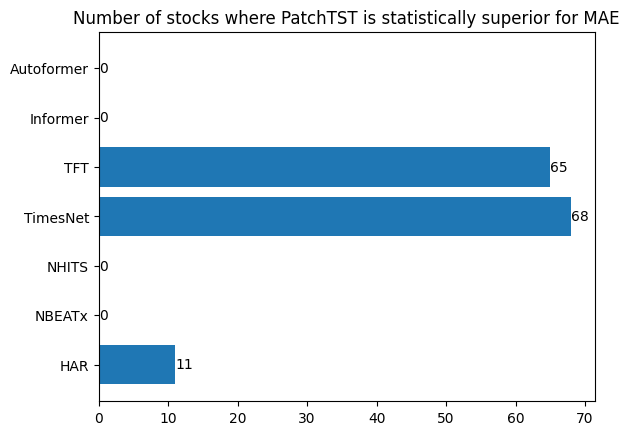

In [36]:


import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([PatchTST_better_HAR, PatchTST_better_NBEATSx, PatchTST_better_NHITS,
              PatchTST_better_TimesNet,PatchTST_better_TFT,PatchTST_better_Informer,PatchTST_better_Autoformer])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically superior for MAE")
plt.show()

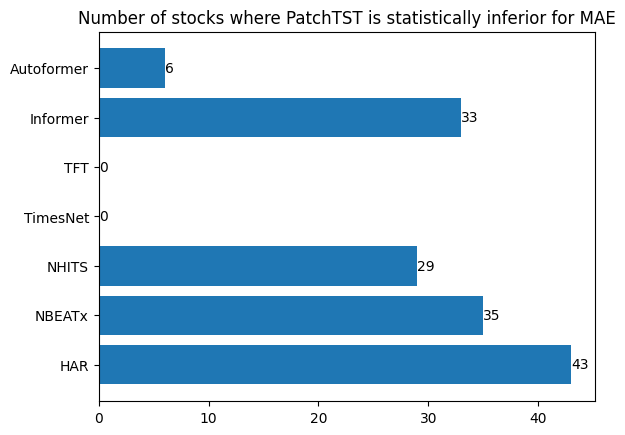

In [37]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([HAR_better_PatchTST, NBEATSx_better_PatchTST, NHITS_better_PatchTST,
              TimesNet_better_PatchTST,TFT_better_PatchTST,Informer_better_PatchTST,Autoformer_better_PatchTST])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically inferior for MAE")
plt.show()

# DM tests with QLIKE

In [38]:
DM_statistics_NBEATSx_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NBEATSx_is_statistically_better)
PatchTST_better_NBEATSx=len(Stocks_where_PatchTST_is_statistically_better)
NBEATSx_better_PatchTST=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: 64
Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BSX', 'C', 'CAT', 'CB', 'CMCSA', 'COP', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'FISV', 'GE', 'GOOG', 'GS', 'HD', 'HON', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MMM', 'MRK', 'MS', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TJX', 'TMO', 'TXN', 'UNP', 'UPS', 'USB', 'WFC']
Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: 0
Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:
[]


In [39]:
DM_statistics_HAR_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than HAR: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than HAR:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than PatchTST: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_HAR_is_statistically_better)
PatchTST_better_HAR=len(Stocks_where_PatchTST_is_statistically_better)
HAR_better_PatchTST=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than HAR: 27
Stocks where PatchTST yields statistically significant better forecasts than HAR:
['AMGN', 'AMZN', 'AXP', 'BA', 'BDX', 'BSX', 'CB', 'CI', 'CRM', 'CVS', 'DHR', 'FISV', 'GE', 'GILD', 'INTU', 'MMM', 'MO', 'NFLX', 'NVDA', 'PEP', 'PNC', 'QCOM', 'SYK', 'TGT', 'UPS', 'USB', 'WFC']
Number of stocks where HAR yields statistically significant better forecasts than PatchTST: 5
Stocks where HAR yields statistically significant better forecasts than PatchTST:
['CME', 'HD', 'IBM', 'MDT', 'NKE']


In [40]:
DM_statistics_TFT_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TFT: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TFT:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TFT_is_statistically_better)
PatchTST_better_TFT=len(Stocks_where_PatchTST_is_statistically_better)
TFT_better_PatchTST=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TFT: 37
Stocks where PatchTST yields statistically significant better forecasts than TFT:
['ADBE', 'AMGN', 'BA', 'BAC', 'BSX', 'C', 'CB', 'COP', 'CSCO', 'CVS', 'D', 'DHR', 'DIS', 'GS', 'HON', 'INTU', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MO', 'MRK', 'MS', 'ORCL', 'PG', 'PNC', 'SBUX', 'SO', 'SYK', 'TXN', 'UNP', 'USB', 'WFC', 'WMT']
Number of stocks where TFT yields statistically significant better forecasts than PatchTST: 0
Stocks where TFT yields statistically significant better forecasts than PatchTST:
[]


In [41]:
DM_statistics_NHITS_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NHITS_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NHITS[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NHITS:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NHITS_is_statistically_better)}")
print(f"Stocks where NHITS yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NHITS_is_statistically_better)
PatchTST_better_NHITS=len(Stocks_where_PatchTST_is_statistically_better)
NHITS_better_PatchTST=len(Stocks_where_NHITS_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: 72
Stocks where PatchTST yields statistically significant better forecasts than NHITS:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FISV', 'GE', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'TJX', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'WFC', 'WMT']
Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: 0
Stocks where NHITS yields statistically significant better forecasts than PatchTST:
[]


In [42]:
DM_statistics_TimesNet_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TimesNet_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TimesNet[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TimesNet:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TimesNet_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0])):
  Stocks_where_TimesNet_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TimesNet_is_statistically_better)}")
print(f"Stocks where TimesNet yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TimesNet_is_statistically_better)
PatchTST_better_TimesNet=len(Stocks_where_PatchTST_is_statistically_better)
TimesNet_better_PatchTST=len(Stocks_where_TimesNet_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: 15
Stocks where PatchTST yields statistically significant better forecasts than TimesNet:
['AAPL', 'AMGN', 'BA', 'BAC', 'C', 'DIS', 'HON', 'MO', 'NVDA', 'ORCL', 'PNC', 'SO', 'UNP', 'USB', 'WFC']
Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: 3
Stocks where TimesNet yields statistically significant better forecasts than PatchTST:
['FIS', 'IBM', 'MDT']


In [43]:
DM_statistics_Informer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Informer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Informer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Informer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Informer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Informer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Informer_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Informer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Informer_is_statistically_better)}")
print(f"Stocks where Informer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Informer_is_statistically_better)
PatchTST_better_Informer=len(Stocks_where_PatchTST_is_statistically_better)
Informer_better_PatchTST=len(Stocks_where_Informer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Informer: 71
Stocks where PatchTST yields statistically significant better forecasts than Informer:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CMCSA', 'COP', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'GE', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where Informer yields statistically significant better forecasts than PatchTST: 0
Stocks where Informer yields statistically significant better forecasts than PatchTST:
[]


In [44]:
DM_statistics_Autoformer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Autoformer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Autoformer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="QLIKE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Autoformer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Autoformer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Autoformer_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Autoformer_is_statistically_better)}")
print(f"Stocks where Autoformer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Autoformer_is_statistically_better)
PatchTST_better_Autoformer=len(Stocks_where_PatchTST_is_statistically_better)
Autoformer_better_PatchTST=len(Stocks_where_Autoformer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: 65
Stocks where PatchTST yields statistically significant better forecasts than Autoformer:
['AAPL', 'ABT', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'BA', 'BAC', 'BDX', 'BSX', 'C', 'CAT', 'CB', 'COP', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'FIS', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MMM', 'MO', 'MRK', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: 0
Stocks where Autoformer yields statistically significant better forecasts than PatchTST:
[]


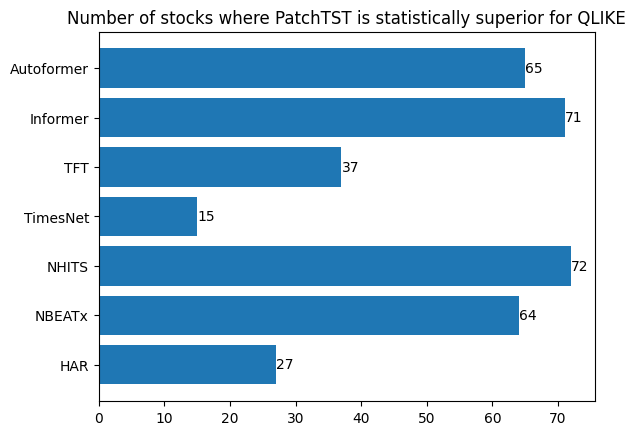

In [45]:


import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([PatchTST_better_HAR, PatchTST_better_NBEATSx, PatchTST_better_NHITS,
              PatchTST_better_TimesNet,PatchTST_better_TFT,PatchTST_better_Informer,PatchTST_better_Autoformer])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically superior for QLIKE")
plt.show()

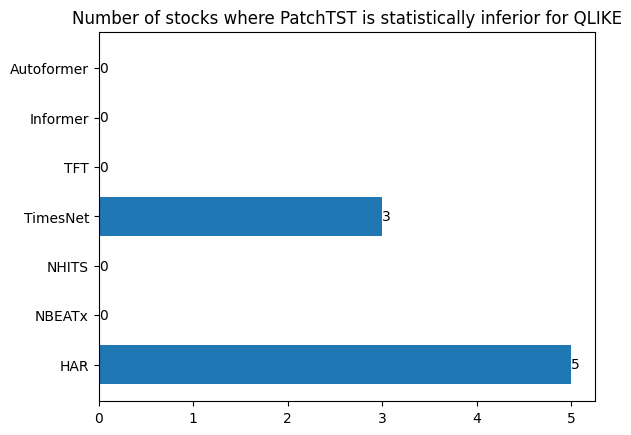

In [46]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([HAR_better_PatchTST, NBEATSx_better_PatchTST, NHITS_better_PatchTST,
              TimesNet_better_PatchTST,TFT_better_PatchTST,Informer_better_PatchTST,Autoformer_better_PatchTST])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically inferior for QLIKE")
plt.show()

# DM tests with MAPE

In [47]:
DM_statistics_NBEATSx_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NBEATSx_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NBEATSx[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NBEATSx_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0])):
  Stocks_where_NBEATSx_is_statistically_better.append(Stocks[np.where(DM_statistics_NBEATSx_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NBEATSx_is_statistically_better)}")
print(f"Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NBEATSx_is_statistically_better)
PatchTST_better_NBEATSx=len(Stocks_where_PatchTST_is_statistically_better)
NBEATSx_better_PatchTST=len(Stocks_where_NBEATSx_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NBEATSx: 0
Stocks where PatchTST yields statistically significant better forecasts than NBEATSx:
[]
Number of stocks where NBEATSx yields statistically significant better forecasts than PatchTST: 80
Stocks where NBEATSx yields statistically significant better forecasts than PatchTST:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']


In [48]:
DM_statistics_HAR_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_HAR_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], HAR[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than HAR: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than HAR:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_HAR_is_statistically_better = []
for i in range(len(np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0])):
  Stocks_where_HAR_is_statistically_better.append(Stocks[np.where(DM_statistics_HAR_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where HAR yields statistically significant better forecasts than PatchTST: {len(Stocks_where_HAR_is_statistically_better)}")
print(f"Stocks where HAR yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_HAR_is_statistically_better)
PatchTST_better_HAR=len(Stocks_where_PatchTST_is_statistically_better)
HAR_better_PatchTST=len(Stocks_where_HAR_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than HAR: 20
Stocks where PatchTST yields statistically significant better forecasts than HAR:
['AAPL', 'AMGN', 'AMZN', 'BAC', 'BMY', 'BSX', 'C', 'CRM', 'CVX', 'GE', 'GILD', 'JPM', 'LLY', 'MRK', 'MS', 'MSFT', 'NFLX', 'PFE', 'SBUX', 'UNH']
Number of stocks where HAR yields statistically significant better forecasts than PatchTST: 36
Stocks where HAR yields statistically significant better forecasts than PatchTST:
['ABT', 'ADBE', 'ADP', 'AMT', 'BDX', 'CI', 'CMCSA', 'CVS', 'DHR', 'DIS', 'FISV', 'GS', 'HD', 'IBM', 'INTC', 'INTU', 'JNJ', 'LMT', 'LOW', 'MCD', 'MMM', 'MO', 'NVDA', 'PEP', 'PG', 'PNC', 'QCOM', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UPS', 'WFC', 'WMT']


In [49]:
DM_statistics_TFT_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TFT_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TFT[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TFT: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TFT:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TFT_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0])):
  Stocks_where_TFT_is_statistically_better.append(Stocks[np.where(DM_statistics_TFT_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TFT yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TFT_is_statistically_better)}")
print(f"Stocks where TFT yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TFT_is_statistically_better)
PatchTST_better_TFT=len(Stocks_where_PatchTST_is_statistically_better)
TFT_better_PatchTST=len(Stocks_where_TFT_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TFT: 47
Stocks where PatchTST yields statistically significant better forecasts than TFT:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'BA', 'BMY', 'BSX', 'CB', 'CI', 'CMCSA', 'COP', 'CRM', 'CSCO', 'CVS', 'D', 'DIS', 'GOOG', 'HD', 'HON', 'INTU', 'ISRG', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MRK', 'MS', 'NVDA', 'ORCL', 'PG', 'PNC', 'QCOM', 'SO', 'SYK', 'TGT', 'TXN', 'UNH', 'USB', 'WFC', 'WMT']
Number of stocks where TFT yields statistically significant better forecasts than PatchTST: 1
Stocks where TFT yields statistically significant better forecasts than PatchTST:
['MO']


In [50]:
DM_statistics_NHITS_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_NHITS_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], NHITS[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than NHITS:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_NHITS_is_statistically_better = []
for i in range(len(np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0])):
  Stocks_where_NHITS_is_statistically_better.append(Stocks[np.where(DM_statistics_NHITS_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: {len(Stocks_where_NHITS_is_statistically_better)}")
print(f"Stocks where NHITS yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_NHITS_is_statistically_better)
PatchTST_better_NHITS=len(Stocks_where_PatchTST_is_statistically_better)
NHITS_better_PatchTST=len(Stocks_where_NHITS_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than NHITS: 0
Stocks where PatchTST yields statistically significant better forecasts than NHITS:
[]
Number of stocks where NHITS yields statistically significant better forecasts than PatchTST: 79
Stocks where NHITS yields statistically significant better forecasts than PatchTST:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']


In [51]:
DM_statistics_TimesNet_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_TimesNet_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], TimesNet[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than TimesNet:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_TimesNet_is_statistically_better = []
for i in range(len(np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0])):
  Stocks_where_TimesNet_is_statistically_better.append(Stocks[np.where(DM_statistics_TimesNet_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: {len(Stocks_where_TimesNet_is_statistically_better)}")
print(f"Stocks where TimesNet yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_TimesNet_is_statistically_better)
PatchTST_better_TimesNet=len(Stocks_where_PatchTST_is_statistically_better)
TimesNet_better_PatchTST=len(Stocks_where_TimesNet_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than TimesNet: 67
Stocks where PatchTST yields statistically significant better forecasts than TimesNet:
['AAPL', 'ABT', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CMCSA', 'CME', 'COP', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'FIS', 'FISV', 'GE', 'GILD', 'GS', 'HD', 'HON', 'INTU', 'ISRG', 'JPM', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']
Number of stocks where TimesNet yields statistically significant better forecasts than PatchTST: 0
Stocks where TimesNet yields statistically significant better forecasts than PatchTST:
[]


In [52]:
DM_statistics_Informer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Informer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Informer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Informer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Informer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Informer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Informer_is_statistically_better.append(Stocks[np.where(DM_statistics_Informer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Informer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Informer_is_statistically_better)}")
print(f"Stocks where Informer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Informer_is_statistically_better)
PatchTST_better_Informer=len(Stocks_where_PatchTST_is_statistically_better)
Informer_better_PatchTST=len(Stocks_where_Informer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Informer: 0
Stocks where PatchTST yields statistically significant better forecasts than Informer:
[]
Number of stocks where Informer yields statistically significant better forecasts than PatchTST: 80
Stocks where Informer yields statistically significant better forecasts than PatchTST:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMT', 'AMZN', 'AXP', 'BA', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COP', 'COST', 'CRM', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DIS', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SO', 'SYK', 'T', 'TGT', 'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']


In [53]:
DM_statistics_Autoformer_vs_PatchTST = np.zeros(len(Stocks))
for i in range(len(Stocks)):
  DM_statistics_Autoformer_vs_PatchTST[i]=dm_test(Actuals[Stocks[i]], Autoformer[Stocks[i]], PatchTST[Stocks[i]], h = 1, crit="MAPE")

Stocks_where_PatchTST_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0])):
  Stocks_where_PatchTST_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST>1.96)[0][i]])

print(f"Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: {len(Stocks_where_PatchTST_is_statistically_better)}")
print("Stocks where PatchTST yields statistically significant better forecasts than Autoformer:")
print(Stocks_where_PatchTST_is_statistically_better)

Stocks_where_Autoformer_is_statistically_better = []
for i in range(len(np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0])):
  Stocks_where_Autoformer_is_statistically_better.append(Stocks[np.where(DM_statistics_Autoformer_vs_PatchTST<-1.96)[0][i]])

print(f"Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: {len(Stocks_where_Autoformer_is_statistically_better)}")
print(f"Stocks where Autoformer yields statistically significant better forecasts than PatchTST:")
print(Stocks_where_Autoformer_is_statistically_better)
PatchTST_better_Autoformer=len(Stocks_where_PatchTST_is_statistically_better)
Autoformer_better_PatchTST=len(Stocks_where_Autoformer_is_statistically_better)

Number of stocks where PatchTST yields statistically significant better forecasts than Autoformer: 0
Stocks where PatchTST yields statistically significant better forecasts than Autoformer:
[]
Number of stocks where Autoformer yields statistically significant better forecasts than PatchTST: 73
Stocks where Autoformer yields statistically significant better forecasts than PatchTST:
['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AMGN', 'AMZN', 'AXP', 'BAC', 'BDX', 'BMY', 'BSX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'CME', 'COST', 'CSCO', 'CVS', 'CVX', 'D', 'DHR', 'DUK', 'FIS', 'FISV', 'GE', 'GILD', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'SBUX', 'SYK', 'T', 'TGT', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WFC', 'WMT']


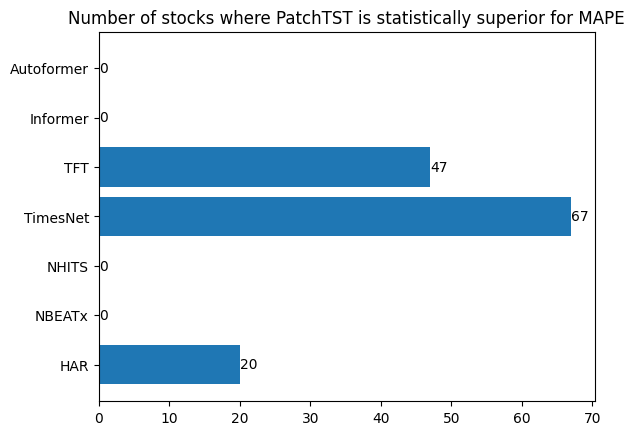

In [54]:


import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([PatchTST_better_HAR, PatchTST_better_NBEATSx, PatchTST_better_NHITS,
              PatchTST_better_TimesNet,PatchTST_better_TFT,PatchTST_better_Informer,PatchTST_better_Autoformer])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically superior for MAPE")
plt.show()

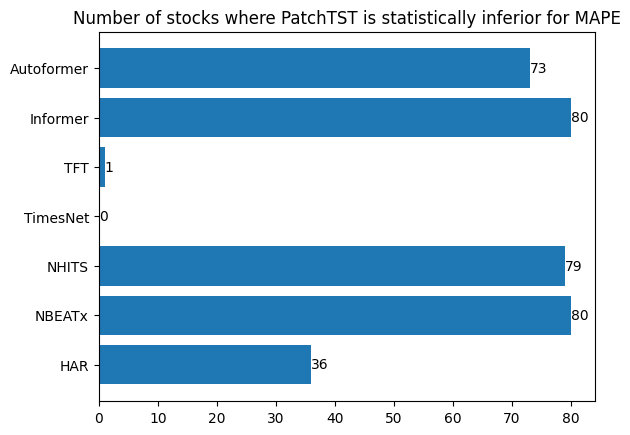

In [55]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["HAR", "NBEATx","NHITS", "TimesNet", "TFT", "Informer", "Autoformer"])
y = np.array([HAR_better_PatchTST, NBEATSx_better_PatchTST, NHITS_better_PatchTST,
              TimesNet_better_PatchTST,TFT_better_PatchTST,Informer_better_PatchTST,Autoformer_better_PatchTST])

fig, ax = plt.subplots()
bars = ax.barh(x,y)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Number of stocks where PatchTST is statistically inferior for MAPE")
plt.show()